<h1>NYC CitiBike Network Assignment</h1>
<li>The file, citibike-tripdata.csv, contains citibike trip data from October 2024
<li>The file contains trip data with the following columns:
<br><br>   
    
    ride_id: Unique identifier for each trip
    rideable_type: Type of bike used
    started_at: Trip start timestamp
    ended_at: Trip end timestamp
    start_station_name, start_station_id: Starting station information
    end_station_name, end_station_id: Ending station information
    start_lat, start_lng: Starting coordinates
    end_lat, end_lng: Ending coordinates
    member_casual: Rider type (member/casual)
<br>
<li>Each record in the data is a trip
<li>The data is described at <a href="https://ride.citibikenyc.com/system-data">Citi Bike System Data</a>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

<h1>STEP 1: Read the data into a dataframe</h1>

In [ ]:
pathfile = 'citibike-tripdata.csv'
df = pd.read_csv(pathfile)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,616E7E74038DCBF9,electric_bike,2024-10-17 17:40:45.993,2024-10-17 18:03:56.498,Goulden Ave & Bedford Park Blvd,8738.01,W 181 St & Riverside Dr,8381.04,40.873870,-73.895330,40.851680,-73.941860,member
1,4993E8CCD15147E4,classic_bike,2024-10-25 23:59:51.593,2024-10-26 00:09:09.720,98 St & 41 Ave,6304.04,104 St & Northern Blvd,6651.01,40.747730,-73.866490,40.757550,-73.864540,casual
2,28586C4580BCDDD5,electric_bike,2024-10-16 14:34:36.684,2024-10-16 14:46:27.222,Fulton St & Clermont Ave,4386.05,Court St & Nelson St,4077.07,40.684157,-73.969223,40.676395,-73.998699,casual
3,46164B02B3A1A388,electric_bike,2024-10-29 13:06:42.323,2024-10-29 13:23:15.483,Hazen St & 20 Ave,7032.06,31 St & Newtown Ave,6923.20,40.772092,-73.895166,40.767549,-73.920933,member
4,E6CA42DA26C40CA4,electric_bike,2024-10-28 06:58:45.631,2024-10-28 07:10:27.007,Dean St & Hoyt St,4446.05,Murray St & West St,5329.08,40.686444,-73.987591,40.715030,-74.012460,member


<h1>STEP 2: Data cleaning and Preprocessing</h1>

<li>Remove data that have any nans in any row</li>
<li>Convert start_station_name, end_station_name to str</li>
<li>Convert started_at, ended_at to datetime</li>
<li>Convert start_station_id, end_station_id to str</li>

In [ ]:
df = df.dropna()
df['start_station_name'] = df['start_station_name'].astype(str)
df['end_station_name'] = df['end_station_name'].astype(str)
df['start_station_id'] = df['start_station_id'].astype(str)
df['end_station_id'] = df['end_station_id'].astype(str)

In [ ]:
# Convert timestamps to datetime
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150020 entries, 0 to 150053
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             150020 non-null  object        
 1   rideable_type       150020 non-null  object        
 2   started_at          150020 non-null  datetime64[ns]
 3   ended_at            150020 non-null  datetime64[ns]
 4   start_station_name  150020 non-null  object        
 5   start_station_id    150020 non-null  object        
 6   end_station_name    150020 non-null  object        
 7   end_station_id      150020 non-null  object        
 8   start_lat           150020 non-null  float64       
 9   start_lng           150020 non-null  float64       
 10  end_lat             150020 non-null  float64       
 11  end_lng             150020 non-null  float64       
 12  member_casual       150020 non-null  object        
dtypes: datetime64[ns](2), float64(4), 

<h1>STEP 3: Feature engineering

<br>Now on the data, create the following features:
<li>Calculate trip duration in minutes(rounded off to two decimal digits) by performing some actions on the two timestamps. Store this in a new column called "duration"
<li>Calculate trip distance in kilometers using the following formula (approx): $$ Distance = 111 \times \sqrt{(lat_{end} - lat_{start})^2 + (lng_{end} - lng_{start})^2} $$
<br> Runde it off to two decimal digits and store this in a new column called "distance"


In [ ]:
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df['duration'] = df['duration'].round(2)

In [ ]:
df['distance'] = np.sqrt(
        (df['end_lat'] - df['start_lat'])**2 +
        (df['end_lng'] - df['start_lng'])**2
    ) * 111
df['distance'] = df['distance'].round(2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150020 entries, 0 to 150053
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             150020 non-null  object        
 1   rideable_type       150020 non-null  object        
 2   started_at          150020 non-null  datetime64[ns]
 3   ended_at            150020 non-null  datetime64[ns]
 4   start_station_name  150020 non-null  object        
 5   start_station_id    150020 non-null  object        
 6   end_station_name    150020 non-null  object        
 7   end_station_id      150020 non-null  object        
 8   start_lat           150020 non-null  float64       
 9   start_lng           150020 non-null  float64       
 10  end_lat             150020 non-null  float64       
 11  end_lng             150020 non-null  float64       
 12  member_casual       150020 non-null  object        
 13  duration            150020 non-nul

<h1>STEP 4: Data filtering</h1>

<br>On the data that we now have, filter the data as follows:
<li> Trip duration has to be 1 minute or more
<li> Trip duration has to be less than 24 hours (or 1440 minutes)
<li> Trip start and end station must be different
<li> Be careful of columns duplication

In [ ]:
df = df[(df['duration'] >= 1) &                # Minimum 1 minute
        (df['duration'] <= 24 * 60) &          # Maximum 24 hours
        (df['start_station_id'] != df['end_station_id'])] # Different start/end stations

<br><li> Drop redundant columns (started_at, ended_at, member_casual, and longitudes and latitudes)
<br><br>

In [ ]:
# Drop redundant columns
df.drop(['started_at', 'ended_at', 'member_casual', 'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147585 entries, 0 to 150053
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             147585 non-null  object 
 1   rideable_type       147585 non-null  object 
 2   start_station_name  147585 non-null  object 
 3   start_station_id    147585 non-null  object 
 4   end_station_name    147585 non-null  object 
 5   end_station_id      147585 non-null  object 
 6   duration            147585 non-null  float64
 7   distance            147585 non-null  float64
dtypes: float64(2), object(6)
memory usage: 10.1+ MB


<h1>STEP 5: Write a function that returns two graphs given a citibike data frame</h1>

<li>Your function should return two things:
<ol>
<li>an Undirected graph
<li>a dictionary with station ids as the key and station name as the value
</ol>
<li>The graph should contain
<ol>
<li>nodes (station ids)
<li>edges (station id, station id)
<li>edge data
<ol>
<li>count: number of trips on the edge
<li>time: average duration - pickup to dropoff - on that edge
<li>distance: distance travelled - on that edge
    <strong>Remember - distance stays the same between two nodes</strong>
</ol>
</ol>
<li><b>Note:</b> the edge (x1,y1) is the same as (y1,x1) even though the start station ids and end station ids are flipped in the dataframe. You may need a helper function or add this logic into your main function

In [ ]:
def identify_edge(str1,str2):
    '''
    This is a helper function to identify unique un-directed edges.
    Given a pickup station id and a dropoff station id (as str),
    a tuple will be returned such that the first str is < second str
    For example identify_edge("2","1") and identify_edge("1","2")
    will both return ("1","2")
    '''
    if str1<str2:
        return (str1, str2)
    else:
        return (str2,str1)

In [ ]:
def get_graph(df):

    G = nx.Graph()

    node_names = dict()
    edge_info = dict()

    for i in df.index: # iterate through each row
        start_station = df.loc[i]['start_station_id']
        end_station = df.loc[i]['end_station_id']

        # if start_station or end_station is not already in node_names,
        # add them to node_names

        if node_names.get(start_station) is None:
            node_names[start_station] = df.loc[i]['start_station_name']
        if node_names.get(end_station) is None:
            node_names[end_station] = df.loc[i]['end_station_name']

        trip_duration = df.loc[i]['duration']
        trip_distance = df.loc[i]['distance']

        # we want to work with the identified edge so that the edge (x1,y1)
        # is the same as the edge (y1, x1)
        identified_edge = identify_edge(start_station,end_station)

        # if identified_edge is not an existing key in edge_info,
        # the count of number of trips = 1
        # the total sum of trip durations is the trip duration of this first trip
        if edge_info.get(identified_edge) is None:
            edge_info[identified_edge] = (1, trip_duration, trip_distance)

        # if identified_edge is an existing key in edge_info,
        # add 1 to the count of number of trips
        # add the trip duration of this trip to the total sum of trip durations
        else:
            count = edge_info[identified_edge][0]+1
            sum_of_trip_durations = edge_info[identified_edge][1]+trip_duration
            edge_info[identified_edge] = (count, sum_of_trip_durations, trip_distance)

    # add the edges, the count of trips on each edge, and the avg duration of each edge to graph
    for key, value in edge_info.items():
        G.add_edge(key[0], key[1], count=value[0], time=value[1]/value[0], distance=value[2])

    return G,node_names

<h1>STEP 6: Create the following graphs using the function above</h1>

<li>G: A graph of all the data in the dataframe
<li>classic_G: A graph containing only data with classic ride type
<li>electric_G: A graph containing only data with electric ride type
<li>Note: for classic_G and electric_G you will need to extract data from the dataframe based on <strong>rideable_type</strong> and we do not consider other types here

In [ ]:
G, nodes = get_graph(df)

In [ ]:
classic_df = df[df['rideable_type'] == 'classic_bike']
electric_df = df[df['rideable_type'] == 'electric_bike']
classic_G = get_graph(classic_df)[0]
electric_G = get_graph(electric_df)[0]

**Below is a sample code to visualize graphs**

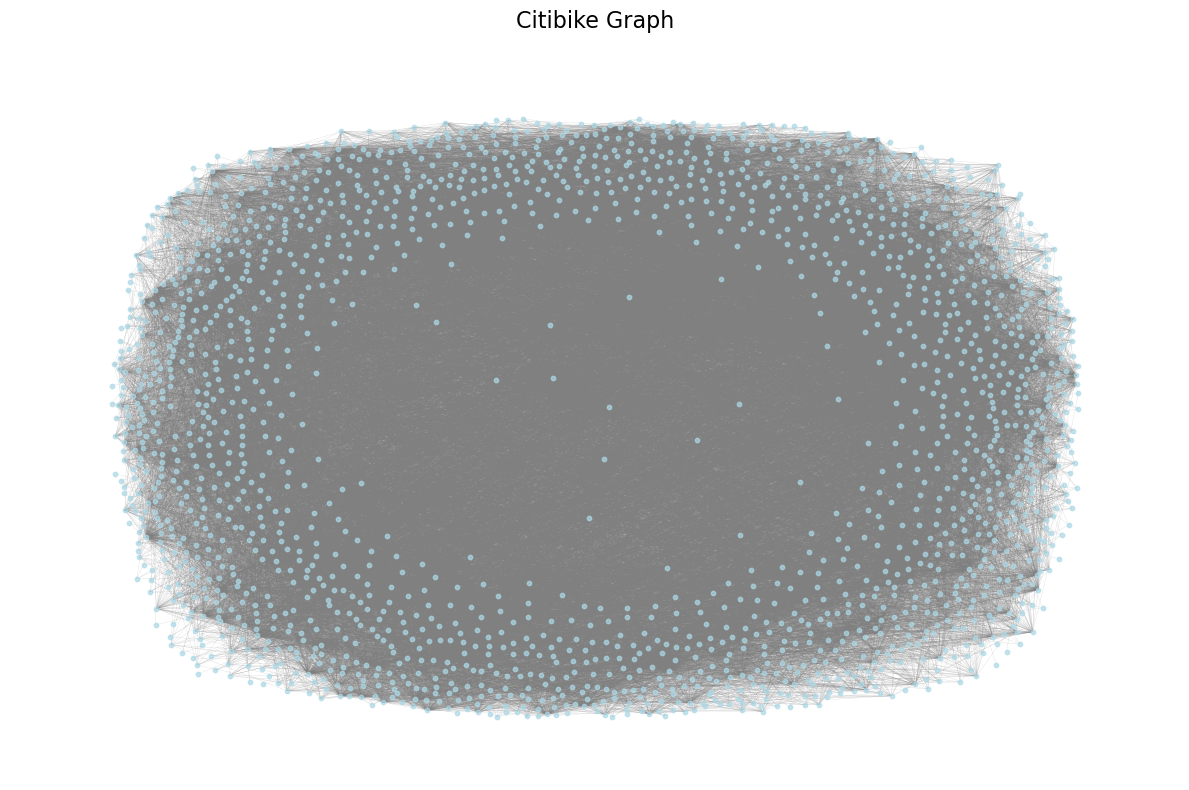

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

layout = nx.spring_layout(G, k=1, iterations=10)

nx.draw(G,
        pos=layout,
        with_labels=False,
        node_color='lightblue',     # Light blue nodes
        node_size=10,               # Larger nodes
        font_size=10,               # Adjust font size
        font_weight='bold',         # Bold labels
        edge_color='gray',          # Gray edges
        width=0.1,                  # Thicker edges
        alpha=0.7)                  # Some transparency

plt.title("Citibike Graph", fontsize=16, pad=20)

plt.tight_layout()

<h1>STEP 7: Answer the following questions for each of the graphs</h1>

<ol>Now we take a deep dive into the citibike trip network system. Please answer the following questions for df, classic_df and electric_df:
<li>Which stations (name) are the best (max degree) and worst connected (min degree)? (Show only first 5 or less)
<li>Travel between which pair of stations is the longest in terms of average duration between trip start and end. Report both the two stations as well as the time in minutes (float).
<li>Travel between which pair of stations is the longest in terms of average distance between trip start_station and end_station. Report both the two stations as well as the distance in kilometers (float).
<li>Which edges are associated with the most and least number of trips?
<li>Which station is "neareast" to all other stations (in terms of time)?
<li>Which station is "neareast" to all other stations (in terms of distance)?
<li>Which station is the most important connector or traffic bottleneck (in terms of trip count)?

<br> **1a. Which stations (name) are the best connected (max degree)?  (Show only top)**

In [ ]:
G_degree_rlist = sorted(G.degree(), key=lambda x: x[1], reverse=True)
classic_degree_rlist = sorted(classic_G.degree(), key=lambda x: x[1], reverse=True)
electric_degree_rlist = sorted(electric_G.degree(), key=lambda x: x[1], reverse=True)

In [ ]:
print("The best connected station in df:", nodes[G_degree_rlist[0][0]])
print("The best connected station in classic_df:", nodes[classic_degree_rlist[0][0]])
print("The best connected station in electric_df:", nodes[electric_degree_rlist[0][0]])

The best connected station in df: W 21 St & 6 Ave
The best connected station in classic_df: W 21 St & 6 Ave
The best connected station in electric_df: W 21 St & 6 Ave


<br> **1b. Which stations (name) are the worst connected (min degree)?  (Show only first 5)**

In [ ]:
G_degree_list = sorted(G.degree(), key=lambda x: x[1], reverse=False)
G_min_degree = G_degree_list[0][1]
G_worst_stations = [nodes[node] for node, degree in G_degree_list if degree == G_min_degree]

classic_degree_list = sorted(classic_G.degree(), key=lambda x: x[1], reverse=False)
classic_min_degree = classic_degree_list[0][1]
classic_worst_stations = [nodes[node] for node, degree in classic_degree_list if degree == classic_min_degree]

electric_degree_list = sorted(electric_G.degree(), key=lambda x: x[1], reverse=False)
electric_min_degree = electric_degree_list[0][1]
electric_worst_stations = [nodes[node] for node, degree in electric_degree_list if degree == electric_min_degree]

In [ ]:
print("The worst connected stations in df:", G_worst_stations[0:5])
print("\nThe worst connected stations in classic_df:", classic_worst_stations[0:5])
print("\nThe worst connected stations in electric_df:", electric_worst_stations[0:5])

The worst connected stations in df: ['93 St & Roosevelt Ave', 'Queens Blvd & Albion Ave', 'St James Ave & 51 Ave', '51 Ave & Van Loon St', 'Taylor St & Bedford Ave']

The worst connected stations in classic_df: ['Prospect Ave & Vanderbilt St', 'E 149 St & Jackson Ave', 'Classon Ave & St Marks Ave', 'Queens Blvd & Albion Ave', '10 St & 2 Ave']

The worst connected stations in electric_df: ['93 St & Roosevelt Ave', 'St James Ave & 51 Ave', '51 Ave & Van Loon St', 'Hoe Ave & Jennings St', 'Nostrand Ave & Myrtle Ave']


<br> **2. Show the pairs of stations with the longest trip in terms of average duration between trip start and end. Report both the two stations as well as the time in minutes (float)**

In [ ]:
G_max = sorted(list(G.edges(data=True)), key=lambda x: x[2]['time'], reverse=True)[0]
classic_max = sorted(list(classic_G.edges(data=True)), key=lambda x: x[2]['time'], reverse=True)[0]
electric_max = sorted(list(electric_G.edges(data=True)), key=lambda x: x[2]['time'], reverse=True)[0]
print("Longest average duration in df: ", nodes[G_max[0]], "to", nodes[G_max[1]],"/ Minutes:",
     (G_max[2]['time']))
print("Longest average duration in classic_df: ", nodes[classic_max[0]], "to", nodes[classic_max[1]],"/ Minutes:",
     (classic_max[2]['time']))
print("Longest average duration in electric_df: ", nodes[electric_max[0]], "to", nodes[electric_max[1]],"/ Minutes:",
     (electric_max[2]['time']))

Longest average duration in df:  W 16 St & The High Line to Cadman Plaza E & Red Cross Pl / Minutes: 1277.49
Longest average duration in classic_df:  W 16 St & The High Line to Cadman Plaza E & Red Cross Pl / Minutes: 1277.49
Longest average duration in electric_df:  Freeman St & Southern Blvd to Beck St & Leggett Ave / Minutes: 563.18


<br> **3. Show the pairs of stations with the longest trip in terms of average distance between trip start_station and end_station. Report both the two stations as well as the distance in kilometers (float)**

In [ ]:
G_max = sorted(list(G.edges(data=True)), key=lambda x: x[2]['distance'], reverse=True)[0]
classic_max = sorted(list(classic_G.edges(data=True)), key=lambda x: x[2]['distance'], reverse=True)[0]
electric_max = sorted(list(electric_G.edges(data=True)), key=lambda x: x[2]['distance'], reverse=True)[0]
print("Longest average distance in df: ", nodes[G_max[0]], "to", nodes[G_max[1]],"/ kilometers:",
     (G_max[2]['distance']))
print("Longest average distance in classic_df: ", nodes[classic_max[0]], "to", nodes[classic_max[1]],"/ kilometers:",
     (classic_max[2]['distance']))
print("Longest average distance in electric_df: ", nodes[electric_max[0]], "to", nodes[electric_max[1]],"/ kilometers:",
     (electric_max[2]['distance']))

Longest average distance in df:  Riverside Dr & Broadway to South St & Whitehall St / kilometers: 20.49
Longest average distance in classic_df:  Lafayette St & E 8 St to Botanical Sq & Webster Ave / kilometers: 19.55
Longest average distance in electric_df:  Riverside Dr & Broadway to South St & Whitehall St / kilometers: 20.49


<br> **4. Which edges are associated with the most and least number of trips? (show all pairs)**

In [ ]:
G_max = sorted(list(G.edges(data=True)), key=lambda x: x[2]['count'], reverse=True)[0]
classic_max = sorted(list(classic_G.edges(data=True)), key=lambda x: x[2]['count'], reverse=True)[0]
electric_max = sorted(list(electric_G.edges(data=True)), key=lambda x: x[2]['count'], reverse=True)[0]
print("Route with the most trips in df: ", nodes[G_max[0]], "to", nodes[G_max[1]],"/ Number of Trips:",
     G_max[2]['count'])
print("Route with the most trips in classic_df: ", nodes[classic_max[0]], "to", nodes[classic_max[1]],"/ Number of Trips:",
     classic_max[2]['count'])
print("Route with the most trips in electric_df: ", nodes[electric_max[0]], "to", nodes[electric_max[1]],"/ Number of Trips:",
     electric_max[2]['count'])

Route with the most trips in df:  9 Ave & W 33 St to 11 Ave & W 41 St / Number of Trips: 270
Route with the most trips in classic_df:  W 22 St & 8 Ave to W 22 St & 10 Ave / Number of Trips: 164
Route with the most trips in electric_df:  9 Ave & W 33 St to 11 Ave & W 41 St / Number of Trips: 228


In [ ]:
G_min = sorted(list(G.edges(data=True)), key=lambda x: x[2]['count'], reverse=False)[0]
classic_min = sorted(list(classic_G.edges(data=True)), key=lambda x: x[2]['count'], reverse=False)[0]
electric_min = sorted(list(electric_G.edges(data=True)), key=lambda x: x[2]['count'], reverse=False)[0]
print("Route with the least trips in df: ", nodes[G_min[0]], "to", nodes[G_min[1]],"/ Number of Trips:",
     G_min[2]['count'])
print("Route with the least trips in classic_df: ", nodes[classic_min[0]], "to", nodes[classic_min[1]],"/ Number of Trips:",
     classic_min[2]['count'])
print("Route with the least trips in electric_df: ", nodes[electric_min[0]], "to", nodes[electric_min[1]],"/ Number of Trips:",
     electric_min[2]['count'])

Route with the least trips in df:  W 181 St & Riverside Dr to Goulden Ave & Bedford Park Blvd / Number of Trips: 1
Route with the least trips in classic_df:  98 St & 41 Ave to 104 St & Northern Blvd / Number of Trips: 1
Route with the least trips in electric_df:  W 181 St & Riverside Dr to Goulden Ave & Bedford Park Blvd / Number of Trips: 1


<br> **5. Which station is "neareast" to all other stations (in terms of distance=time)?**

In [ ]:
from networkx.algorithms import closeness_centrality, betweenness_centrality

In [ ]:
c_G = closeness_centrality(G, distance='time')
c_classic_G = closeness_centrality(classic_G, distance='time')
c_electric_G = closeness_centrality(electric_G, distance='time')

In [ ]:
print("The most central station in df using time as distance:", nodes[max(c_G.items(),key=lambda x: x[1])[0]])
print("The most central station in classic_df using time as distance:", nodes[max(c_classic_G.items(),key=lambda x: x[1])[0]])
print("The most central station in electric_df using time as distance:", nodes[max(c_electric_G.items(),key=lambda x: x[1])[0]])

The most central station in df using time as distance: Davis St & Jackson Ave
The most central station in classic_df using time as distance: E 22 St & 2 Ave
The most central station in electric_df using time as distance: E 63 St & 3 Ave


<br> **6. Which station is "neareast" to all other stations (in terms of distance=distance)?**

In [ ]:
d_G = closeness_centrality(G, distance='distance')
d_classic_G = closeness_centrality(classic_G, distance='distance')
d_electric_G = closeness_centrality(electric_G, distance='distance')

In [ ]:
print("The most central station in df using distance as distance:", nodes[max(d_G.items(),key=lambda x: x[1])[0]])
print("The most central station in classic_df using distance as distance:", nodes[max(d_classic_G.items(),key=lambda x: x[1])[0]])
print("The most central station in electric_df using distance as distance:", nodes[max(d_electric_G.items(),key=lambda x: x[1])[0]])

The most central station in df using distance as distance: Davis St & Jackson Ave
The most central station in classic_df using distance as distance: Leonard St & Nassau Ave
The most central station in electric_df using distance as distance: Davis St & Jackson Ave


<br> **7. Which station is the most important connector or traffic bottleneck (in terms of trip count)?**

In [ ]:
b_G = betweenness_centrality(G, weight='count')
b_classic_G = betweenness_centrality(classic_G, weight='count')
b_electric_G = betweenness_centrality(electric_G, weight='count')

In [ ]:
print("The bottleneck node in df:", nodes[max(b_G.items(),key=lambda x: x[1])[0]])
print("The bottleneck node in classic_df:", nodes[max(b_classic_G.items(),key=lambda x: x[1])[0]])
print("The bottleneck node in electric_df:", nodes[max(b_electric_G.items(),key=lambda x: x[1])[0]])

The bottleneck node in df: Leonard St & Nassau Ave
The bottleneck node in classic_df: Leonard St & Nassau Ave
The bottleneck node in electric_df: Leonard St & Nassau Ave


<h1>STEP 8: Shortest path and shortest duration</h1>

**Find the shortest path and the shortest time duration between "Riverside Dr & Broadway" and "Botanical Sq & Webster Ave" in G.**

In [ ]:
station1 = next((key for key, value in nodes.items() if value == 'Riverside Dr & Broadway'), None)
station2 = next((key for key, value in nodes.items() if value == 'Botanical Sq & Webster Ave'), None)

In [ ]:
station1

'8616.06'

In [ ]:
station2

'8646.02'

In [ ]:
nx.dijkstra_path(G, station1, station2, weight='time')

['8616.06', '8692.04', '8682.06', '8646.02']

In [ ]:
nx.dijkstra_path_length(G, station1, station2, weight='time')

19.060000000000002

**Find the longest shortest path and its time duration in G**

In [ ]:
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='time'))

max_length = 0
pair = (None, None)

# Iterate through the pairs to find the max length and corresponding start/end stations
for start, ends in path_lengths.items():
    for end, length in ends.items():
        if length > max_length:
            max_length = length
            pair = (start, end)

# Retrieve the path corresponding to the longest shortest path
longest_path = nx.dijkstra_path(G, pair[0], pair[1], weight='time')

print("The longest shortest path:", longest_path)
print("The length of the path:", max_length)

The longest shortest path: ['3526.04', '3751.05', '4016.03', '5550.09', '6319.07', '7180.02', '7835.10', '7974.01', '8118.02', '7991.01']
The length of the path: 244.39499999999998
